In [1]:
import Pkg; Pkg.activate("."); Pkg.instantiate()

  Activating project at `~/.julia/dev/RxInferThesisExperiments`


In [15]:
using RxInferThesisExperiments, RxInfer, StaticArrays, Plots
using AppleAccelerate, LinearAlgebra, StableRNGs, Random, BenchmarkTools

In [3]:
# Hot fixes for `ReactiveMP`
ReactiveMP.cholinv(x::UniformScaling) = inv(x.λ) * I
ReactiveMP.cholinv(x::SMatrix) = inv(x)
ReactiveMP.fastcholesky(x::SMatrix) = ReactiveMP.fastcholesky(Matrix(x))

In [4]:
const environment = DoublePendulum(γ = 5.0)

DoublePendulum()

In [5]:
f(state) = state_transition(environment)(state)

f (generic function with 1 method)

In [6]:
@model function double_pendulum(T, z_start)
    
    z = randomvar(T)
    y = datavar(Float64, T)
    σ ~ Gamma(0.001, 100.0)
    
    Σ = constvar(SMatrix{4, 4}(1000 * diageye(4)))
    c = constvar(SA[ 0.0, 1.0, 0.0, 0.0 ])
    
    z[1] ~ MvNormal(mean = z_start, covariance = SMatrix{4, 4}(diageye(4)))
    y[1] ~ Normal(mean = dot(z[1], c), precision = σ)
    
    for t in 2:T
        z[t] ~ MvNormal(mean = f(z[t - 1]), precision = Σ)
        y[t] ~ Normal(mean = dot(z[t], c), precision = σ)
    end
end

@meta function double_pendulum_meta()
    f() -> Linearization()
end

@constraints function double_pendulum_constraints()
    q(z, σ) = q(z)q(σ)
end

double_pendulum_constraints (generic function with 1 method)

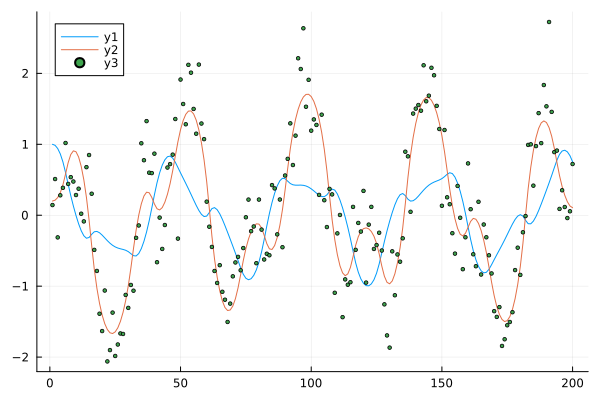

In [75]:
T = 200

states, observations = rand(environment, T);

# RxInferThesisExperiments.animate_double_pendulum(states[1:min(100, lastindex(states))])

# prange = 300:700
prange = firstindex(states):lastindex(states)

plot(prange, getindex.(states, 1)[prange])
plot!(prange, getindex.(states, 2)[prange])
scatter!(prange, observations[prange], ms = 2)

In [89]:
@time results = inference(
    model = double_pendulum(T, states[begin]),
    data = (y = observations, ),
    meta = double_pendulum_meta(),
    constraints = double_pendulum_constraints(),
    returnvars = (z = KeepLast(), σ = KeepLast()),
    iterations = 2,
    initmarginals = (σ = Gamma(0.001, 100.0), ),
    options = (limit_stack_depth = 500, )
)

  0.017852 seconds (236.68 k allocations: 22.560 MiB)


Inference results:
  Posteriors       | available for (σ, z)


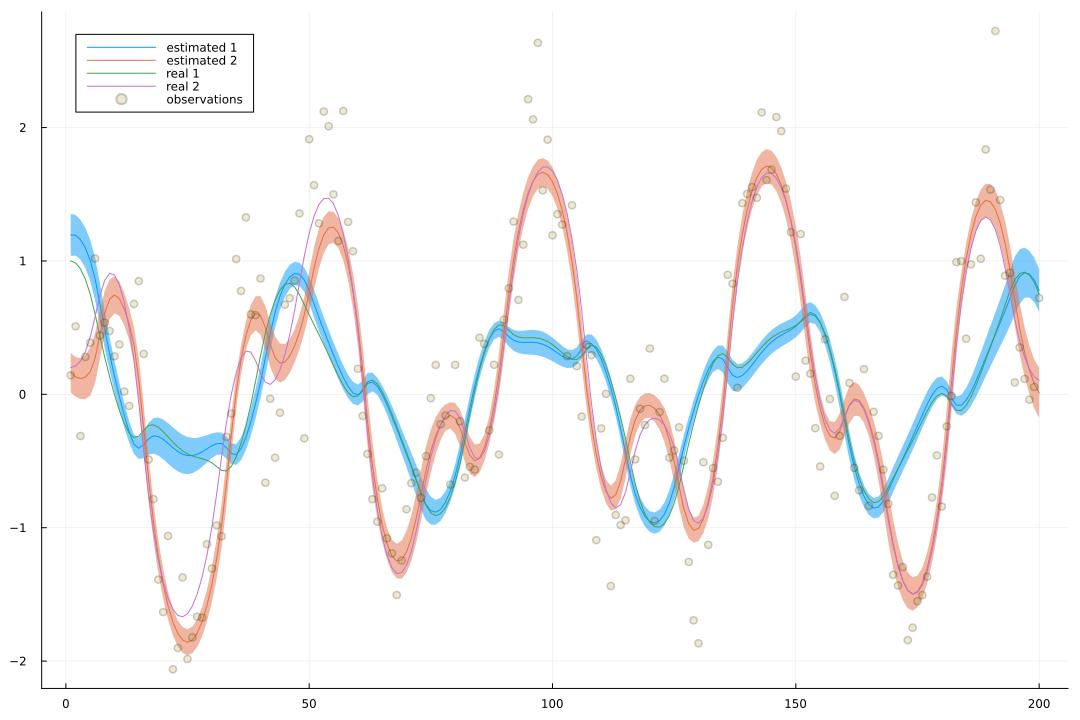

In [77]:
em = mean.(results.posteriors[:z])
ev = std.(results.posteriors[:z])
p = plot(size=(1080, 720))
plot!(prange, getindex.(em, 1)[prange], ribbon = getindex.(ev, 1, 1), label = "estimated 1")
plot!(prange, getindex.(em, 2)[prange], ribbon = getindex.(ev, 2, 2), label = "estimated 2")
plot!(prange, getindex.(states, 1)[prange], label = "real 1")
plot!(prange, getindex.(states, 2)[prange], label = "real 2")
scatter!(prange, getindex.(observations, 1)[prange], ms = 4, alpha = 0.2, label = "observations")

In [78]:
if false
    GC.gc(true)
    benchmark = @benchmark inference(
        model = double_pendulum($T, $(states[begin])),
        data = (y = $observations, ),
        meta = double_pendulum_meta(),
        constraints = double_pendulum_constraints(),
        returnvars = (z = KeepLast(), σ = KeepLast()),
        iterations = 2,
        initmarginals = (σ = Gamma(0.001, 1000.0), ),
        options = (limit_stack_depth = 500, )
    )
    GC.gc(true)
    benchmark
end

In [79]:
import Turing, ReverseDiff
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)

true

In [83]:
Turing.@model function double_pendulum(y, T, z_start)
    
    z = Vector{Vector{Float64}}(undef, T)
    σ ~ Gamma(0.001, 100.0)
    
    Σ = 0.001 * diageye(4)
    c = [ 0.0, 1.0, 0.0, 0.0 ]
    
    z[1] ~ MvNormal(convert(Vector, z_start), diageye(4))
    y[1] ~ Normal(dot(z[1], c), sqrt(σ))
    
    for t in 2:T
        z[t] ~ MvNormal(convert(Vector, f(z[t - 1])), Σ)
        y[t] ~ Normal(dot(z[t], c), sqrt(σ))
    end
end

double_pendulum (generic function with 3 methods)

In [84]:
Base.:(+)(r::ReverseDiff.TrackedArray{V, D}, l::StaticArray{S, T, 1} where {T, S<:Tuple}) where {V, D} = +(r, convert(Vector, l))

In [85]:
chain = Turing.sample(double_pendulum(observations, T, states[begin]), Turing.NUTS(), 100);

┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:06:20


In [86]:
reshape_turing_data(data) = transpose(reshape(data, (4, Int(length(data) / 4))))

reshape_turing_data (generic function with 1 method)

In [87]:
z = Turing.get(chain, :z);

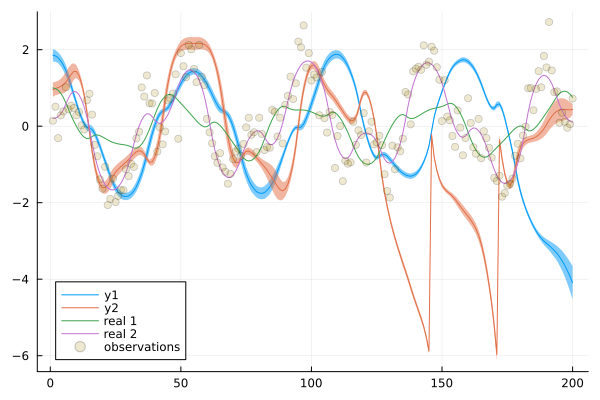

In [88]:
mzt = reshape_turing_data([ mean(z.z[i].data) for i in 1:4T ])
rzt = reshape_turing_data([ std(z.z[i].data) for i in 1:4T ])

plot(1:T, mzt[:, 1:2], ribbon = rzt)
plot!(prange, getindex.(states, 1)[prange], label = "real 1")
plot!(prange, getindex.(states, 2)[prange], label = "real 2")
scatter!(prange, getindex.(observations, 1)[prange], ms = 4, alpha = 0.2, label = "observations")